In [2]:
import numpy as np
import matplotlib.pyplot as plt
import shapefile
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Rectangle, Polygon
from cmocean import cm
from scipy.io import loadmat
from importlib import util
import os
import warnings

# Load Michael's bathy tools
spec = util.spec_from_file_location(
    'bathy_readers.py', '/ocean/mdunphy/MEOPAR/analysis-michael/bathymetry/bathy_readers.py',
)
bathy_readers = util.module_from_spec(spec)
spec.loader.exec_module(bathy_readers)

%matplotlib inline
plt.rcParams['font.size'] = 13
warnings.simplefilter('ignore')

In [3]:
def plot_basemap(
    ax, w_map, color='Burlywood', lons=None, lats=None, xloc=None,
    offset=[None, None], fill=True, zorder=[0, 1, 2],
):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.arange(*np.floor([w_map[0], w_map[1] + 1]))
    if lats is None:
        lats = np.arange(*np.floor([w_map[2], w_map[3] + 1]))
    
    # Labels
    if xloc == 'top':
        labels = [[0, 0, 1, 0], [1, 0, 0, 0]]
    else:
        labels = [[0, 0, 0, 1], [1, 0, 0, 0]]
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    if fill:
        m.fillcontinents(color=color, zorder=zorder[0])
    m.drawmeridians(lons, labels=labels[0], color='k', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(lats, labels=labels[1], color='k', xoffset=offset[0], zorder=zorder[2])
    m.drawrivers(zorder=zorder[2])
    
    return m

In [4]:
FraserMain = [
    'BBAR', 'COTR', 'DOGC', 'FRCN', 'HARR', 'LFRA', 'MFRA',
    'MORK', 'NARC', 'SETN', 'TABR', 'TWAC', 'UFRA',
]

FraserBasin = [
    'ADMS', 'BBAR', 'BIGC', 'BLAR', 'BONP', 'BOWR', 'BRID', 'CARR',
    'CHES', 'CHIL', 'CHIR', 'CHWK', 'CLWR', 'COTR', 'DEAD', 'DOGC',
    'DRIR', 'EUCH', 'EUCL', 'FRAN', 'FRCN', 'GRNL', 'HARR', 'HERR',
    'HORS', 'LCHL', 'LCHR', 'LEUT', 'LFRA', 'LILL', 'LNIC', 'LNRS',
    'LNTH', 'LSAL', 'LTRE', 'MAHD', 'MCGR', 'MFRA', 'MIDR', 'MORK',
    'MURT', 'MUSK', 'NARC', 'NAZR', 'NECR', 'NICL', 'QUES', 'SAJR',
    'SALR', 'SETN', 'SHUL', 'STHM', 'STUL', 'STUR', 'TABR', 'TAKL',
    'TASR', 'THOM', 'TWAC', 'UCHR', 'UEUT', 'UFRA', 'UNRS', 'UNTH',
    'USHU', 'UTRE', 'WILL',
]

FraserLakes = [
    'ADMS', 'BIGC', 'CARR', 'CLWR', 'EUCL', 'FRAN', 'HARR', 'LFRA',
    'LILL', 'LNRS', 'MURT', 'SETN', 'SHUL', 'STHM', 'STUL', 'TAKL',
    'TASR', 'THOM', 'UFRA', 'UNRS', 'USHU', 'UTRE',
]

In [5]:
# Load Cascadia bathymetry
y_slice = slice(2650, 3700)
x_slice = slice(3950, 5000)
x, y, z, p = bathy_readers.getcascadia('/ocean/bmoorema/research/data/cascadia/cascadia.bil')
z = z[x_slice, y_slice][::5, ::5]
z[z > 500] = 500
coords = p(*np.meshgrid(x[y_slice][::5], y[x_slice][::5]), inverse=True)

# Load belts
matlab_path = '/ocean/bmoorema/research/matlab/maps'
Mnlndcst = loadmat(os.path.join(matlab_path, 'Mnlndcst2'))['ncst']
Belts = loadmat(os.path.join(matlab_path, 'Belts2'))['Belts'][0][0]

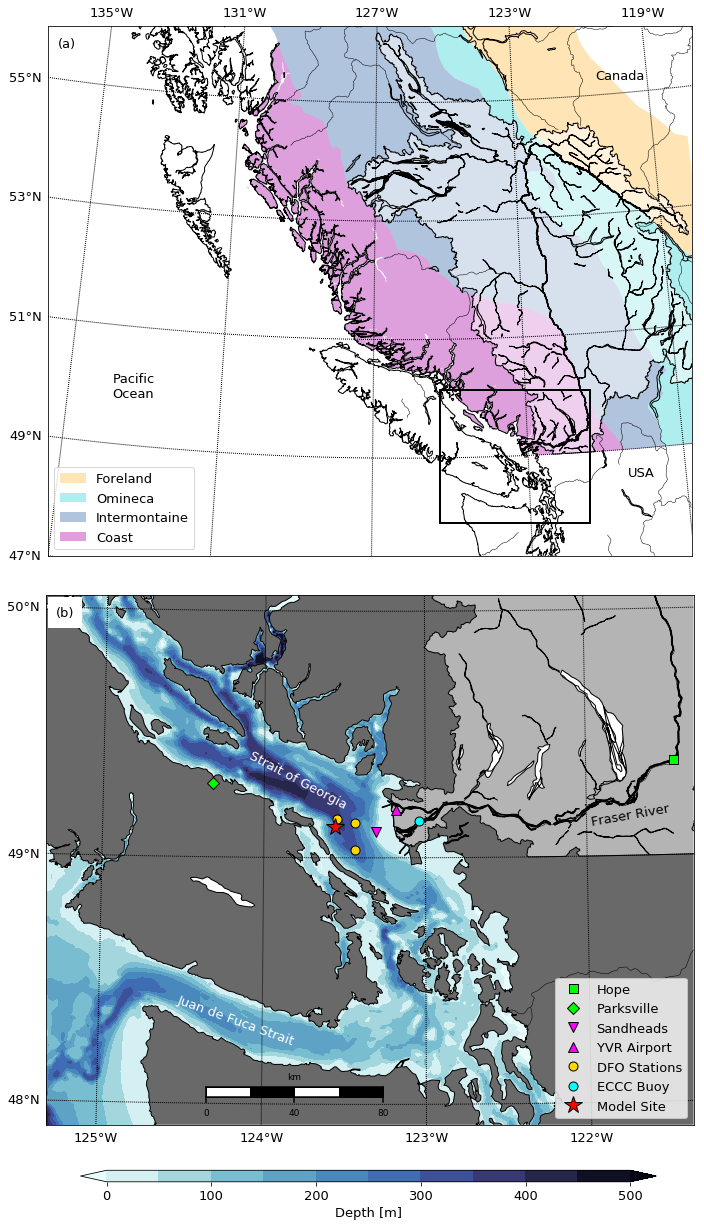

In [6]:
# Make plot window
fig, axs = plt.subplots(2, 1, figsize=(10, 16))
fig.tight_layout()

# Define map window
ms = []
w_maps = [[-135, -117.5, 47, 56], [-125.3, -121.3, 47.9, 50.05]]
lons = [range(-135, -117, 4), range(-126, -120)]
lats = [range(47, 57, 2), range(48, 51)]
for ax, w_map, lon, lat, fill, xloc in zip(axs, w_maps, lons, lats, [False, True], ['top', None]):
    ms.append(plot_basemap(
        ax, w_map, color='dimgray', lons=lon, lats=lat, xloc=xloc, fill=fill,
    ))
    
# Plot belts
x, y = ms[0](Mnlndcst[:, 0], Mnlndcst[:, 1])
index = np.where(np.isnan(Mnlndcst[:, 0]))[0]
for i in range(1, 100):
    label = None
    if i == 1:
        label = 'Coast'
    chunk = slice(index[i-1]+1, index[i])
    axs[0].add_patch(Polygon(
        np.concatenate((x[chunk, np.newaxis][::100], y[chunk, np.newaxis][::100]), axis=1),
        edgecolor='none', facecolor='plum', label=label, zorder=-10,
    ))
beltcolors = ['moccasin', 'paleturquoise', 'lightsteelblue', 'w']
beltlabels = ['Foreland', 'Omineca', 'Intermontaine', None]
for i, color, label in zip(range(4), beltcolors, beltlabels):
    ncst = Belts[i][0][0][0]
    if i == 3:
        ncst[0, 0], ncst[-1, 0] = -117, -117
    x, y = ms[0](ncst[:, 0], ncst[:, 1])
    axs[0].add_patch(Polygon(
        np.concatenate((x[:, np.newaxis], y[:, np.newaxis]), axis=1),
        edgecolor='none', facecolor=color, label=label, zorder=-10,
    ))

# Plot Cascadia bathymetry
x_map, y_map = ms[1](*coords)
c = axs[1].contourf(x_map, y_map, z, levels=range(0, 510, 50), cmap=cm.ice_r, extend='both', zorder=-1)

# Add Fraser watershed boundaries
S = shapefile.Reader('/ocean/rich/more/mmapbase/bcgeo/FWNMDWTRSH/FWNMDWTRSH_polygon')
for i, record in enumerate(S.records()):
    if record[9] == 'Fraser River':
        ncst = np.array(S.shape(i).points)
for ax, m in zip(axs, ms):
    x, y = m(ncst[::10, 0], ncst[::10, 1])
    ax.add_patch(Polygon(
        np.concatenate((x[:, np.newaxis], y[:, np.newaxis]), axis=1),
        edgecolor='k', facecolor=[1, 1, 1, 0.5], zorder=0
    ))

# Plot Fraser watershed rivers and main stem
S = shapefile.Reader('/ocean/rich/more/mmapbase/bcgeo/FWRVRSPL/FWRVRSPL')
for i, record in enumerate(S.records()):
    for wtshd in FraserBasin:
        if wtshd in record[15] and record[4] > 50:
            ncst = np.array(S.shape(i).points)
            if i == 2972:
                ncst = ncst[:np.where(np.diff(ncst, axis=0) > 0.1)[0][0], :]
            for ax, m in zip(axs, ms):
                x, y = m(ncst[::100, 0], ncst[::100, 1])
                ax.plot(x, y, 'k-', linewidth=1)
    for wtshd in FraserMain:
        if wtshd in record[15] and record[16] == 'NONE':
            ncst = np.array(S.shape(i).points)
            if i == 2972:
                ncst = ncst[:np.where(np.diff(ncst, axis=0) > 0.1)[0][0], :]
            for ax, m in zip(axs, ms):
                x, y = m(ncst[::100, 0], ncst[::100, 1])
                ax.plot(x, y, 'k-', linewidth=1.5)

# Plot Fraser watershed lakes
S = shapefile.Reader('/ocean/rich/more/mmapbase/bcgeo/FWLKSPL/FWLKSPL')
for i, record in enumerate(S.records()):
    for wtshd in FraserLakes:
        if wtshd in record[18] and record[4] > 500:
            ncst = np.array(S.shape(i).points)
            if i == 209874:
                ncst = ncst[:np.where(np.diff(ncst, axis=0) > 0.1)[0][0], :]
            for ax, m in zip(axs, ms):
                x, y = m(ncst[::100, 0], ncst[::100, 1])
                ax.add_patch(Polygon(
                    np.concatenate((x[:, np.newaxis], y[:, np.newaxis]), axis=1),
                    edgecolor='k', facecolor='w',
                ))

# Geographic Labels
axs[1].text(0.31, 0.69, 'Strait of Georgia', transform=axs[1].transAxes, rotation=-28, color='w')
axs[1].text(0.2, 0.23, 'Juan de Fuca Strait', transform=axs[1].transAxes, rotation=-20, color='w')
axs[1].text(0.84, 0.59, 'Fraser River', transform=axs[1].transAxes, rotation=10)
axs[0].text(0.1, 0.3, 'Pacific\nOcean', transform=axs[0].transAxes)
axs[0].text(0.85, 0.9, 'Canada', transform=axs[0].transAxes)
axs[0].text(0.9, 0.15, 'USA', transform=axs[0].transAxes)

# Stations
stations = {
    'Hope':         {'lon': -121.4522, 'lat': 49.3855, 'marker': 's', 'size': 9,  'label': True,  'color': 'lime'},
    'Parksville':   {'lon': -124.3200, 'lat': 49.3000, 'marker': 'D', 'size': 8,  'label': True,  'color': 'lime'},
    'Sandheads':    {'lon': -123.3033, 'lat': 49.1050, 'marker': 'v', 'size': 10, 'label': True,  'color': 'magenta'},
    'YVR Airport':  {'lon': -123.1844, 'lat': 49.1939, 'marker': '^', 'size': 10, 'label': True,  'color': 'magenta'},
    'DFO Stations': {'lon': -123.5497, 'lat': 49.1562, 'marker': 'o', 'size': 9,  'label': True,  'color': 'gold'},
    'DFO2':         {'lon': -123.4370, 'lat': 49.1400, 'marker': 'o', 'size': 9,  'label': False, 'color': 'gold'},
    'DFO3':         {'lon': -123.4368, 'lat': 49.0302, 'marker': 'o', 'size': 9,  'label': False, 'color': 'gold'},
    'ECCC Buoy':    {'lon': -123.0390, 'lat': 49.1480, 'marker': 'o', 'size': 9,  'label': True,  'color': 'cyan'},
    'Model Site':   {'lon': -123.5581, 'lat': 49.1248, 'marker': '*', 'size': 18, 'label': True,  'color': 'r'},
}
for station in stations.items():
    x, y = ms[1](station[1]['lon'], station[1]['lat'])
    label = None
    if station[1]['label']:
        label = station[0]
    axs[1].plot(
        x, y, linestyle='', marker=station[1]['marker'], color=station[1]['color'],
        markersize=station[1]['size'], markeredgecolor='k', label=label,
    )

# Final annotations
x, y = ms[0](w_maps[1][0], w_maps[1][2])
dx, dy = ms[0](w_maps[1][1], w_maps[1][3])
dx, dy = dx - x, dy - y
axs[0].add_patch(Rectangle([x, y], dx, dy, edgecolor='k', fill=False, linewidth=2))
ms[1].drawmapscale(-123.8, 48.05, -123, 49, 80, barstyle='fancy')
cax = fig.add_axes([0.11, -0.02, 0.8, 0.01])
cbar = fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]')
handles, labels = axs[0].get_legend_handles_labels()
handles = handles[1:] + [handles[0]]
labels = labels[1:] + [labels[0]]
axs[0].legend(handles, labels, loc=3)
axs[1].legend(loc=4)
axs[0].text(0.015, 0.96, '(a)', transform=axs[0].transAxes)
axs[1].text(0.015, 0.96, '(b)', transform=axs[1].transAxes, zorder=11)
axs[1].add_patch(Rectangle((0.003, 0.94), 0.05, 0.055, color='w', transform=axs[1].transAxes, zorder=10))

plt.show()